## Title Cell

In [51]:
# Import dependencies
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [52]:
# Import csv, convert to a dataframe. List the columns so we know how to clean it up
diabetes_csv = pd.read_csv("source_data/diabetes_indicators.csv")
diabetes_df = pd.DataFrame(diabetes_csv)
diabetes_df.columns

Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')

## William

In [53]:
# Trim the dataframe so it is only our variables of interest
df_trimmed = diabetes_df[["Diabetes_012", "Income", "Education", "Age", "HvyAlcoholConsump", "Fruits", "Veggies", "CholCheck", "HighChol", "PhysActivity", "BMI"]].copy()
df_trimmed.head()

,Diabetes_012,Income,Education,Age,HvyAlcoholConsump,Fruits,Veggies,CholCheck,HighChol,PhysActivity,BMI
0,0.0,3.0,4.0,9.0,0.0,0.0,1.0,1.0,1.0,0.0,40.0
1,0.0,1.0,6.0,7.0,0.0,0.0,0.0,0.0,0.0,1.0,25.0
2,0.0,8.0,4.0,9.0,0.0,1.0,0.0,1.0,1.0,0.0,28.0
3,0.0,6.0,3.0,11.0,0.0,1.0,1.0,1.0,0.0,1.0,27.0
4,0.0,4.0,5.0,11.0,0.0,1.0,1.0,1.0,1.0,1.0,24.0


In [54]:
# Group by fruit consumption and diabetes status, count the number of participants for each category
dia_fruits = df_trimmed.groupby(["Fruits", "Diabetes_012"]).size().reset_index(name='count')

# ***(I think we could also use a .loc here to make it easier - but this works)***
# Separate 0 fruit values from 1 fruit values, copying the tables so we can easily perform actions on them
nofruits = dia_fruits[dia_fruits["Fruits"] == 0].copy()
yesfruits = dia_fruits[dia_fruits["Fruits"] == 1].copy()

# Find the total respondents per category (fruit and no fruit)
# Create a new column for the proportion of respondents in each row out of their respective category
nofruits_sum = nofruits["count"].sum()
nofruits["proportion"] = (nofruits["count"] / nofruits_sum) * 100

yesfruits_sum = yesfruits["count"].sum()
yesfruits["proportion"] = (yesfruits["count"] / yesfruits_sum) * 100

# Using the pd.concat() function, combine the two tables into the new fruitstack df, which shows the proportions
fruitstack = pd.concat([nofruits, yesfruits], ignore_index=False)
fruitstack

,Fruits,Diabetes_012,count,proportion
0,0.0,0.0,76287,82.221767
1,0.0,1.0,1842,1.985299
2,0.0,2.0,14653,15.792934
3,1.0,0.0,137416,85.405661
4,1.0,1.0,2789,1.733396
5,1.0,2.0,20693,12.860943


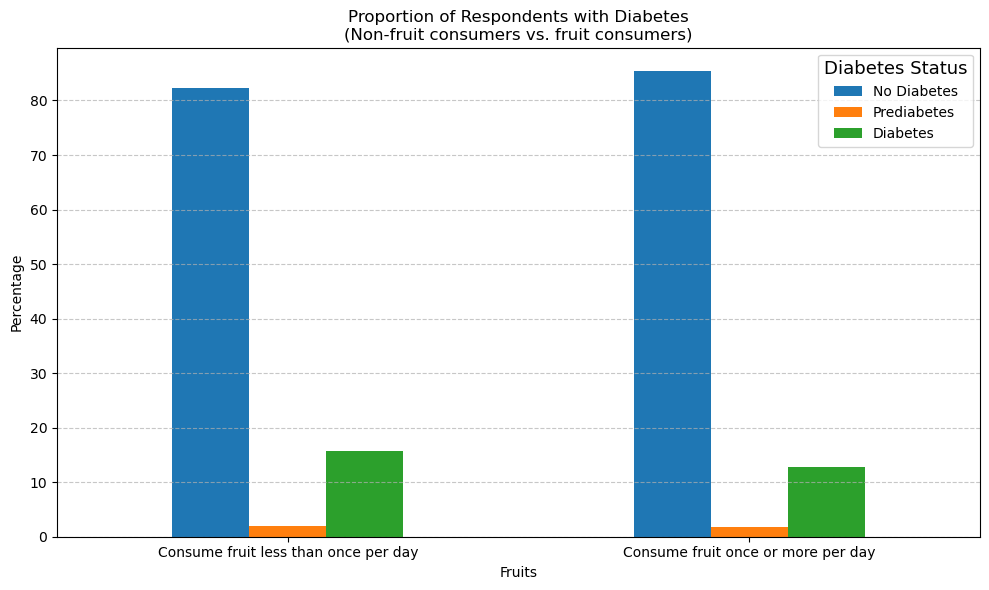

In [55]:
# Set up pivot table to reorganize fruitstack df
pivot_df = fruitstack.pivot(index='Fruits', columns='Diabetes_012', values='proportion')

# Rename columns for easy display formatting
pivot_df.columns = ['No Diabetes', 'Prediabetes', 'Diabetes']

# Rename indices for easy display formatting
index_mapping = {0.0: 'Consume fruit less than once per day', 1.0: 'Consume fruit once or more per day'}
pivot_df.index = pivot_df.index.map(index_mapping)

# Plot the table
pivot_df.plot(kind='bar', figsize=(10, 6))
plt.title('Proportion of Respondents with Diabetes\n(Non-fruit consumers vs. fruit consumers)')
plt.xlabel('Fruits')
plt.ylabel('Percentage')
plt.xticks(ticks=range(len(pivot_df.index)), labels=pivot_df.index, rotation=0)
plt.legend(title='Diabetes Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Chinna

## Abigail

In [56]:


# Group by cholesterol check status and diabetes status
dia_chol_check = df_trimmed.groupby(["CholCheck", "Diabetes_012"]).size().reset_index(name='count')
colors = ['#CACACA','#78909C','#616161']

# Separate the categories of those who did not have a cholesterol check (0) and those who did (1)
nocholcheck = dia_chol_check[dia_chol_check["CholCheck"] == 0].copy()
yescholcheck = dia_chol_check[dia_chol_check["CholCheck"] == 1].copy()
colors = ['#CACACA','#78909C','#616161']

# Find the total respondents per category (cholesterol check and no cholesterol check)
# Create a new column for the proportion of respondents in each row out of their respective category
nocholcheck_sum = nocholcheck["count"].sum()
nocholcheck["proportion"] = (nocholcheck["count"] / nocholcheck_sum) * 100

yescholcheck_sum = yescholcheck["count"].sum()
yescholcheck["proportion"] = (yescholcheck["count"] / yescholcheck_sum) * 100

# Using the pd.concat() function, combine the two tables into a new DataFrame that shows the proportions
cholcheck_stack = pd.concat([nocholcheck, yescholcheck], ignore_index=False)
cholcheck_stack


,CholCheck,Diabetes_012,count,proportion
0,0.0,0.0,9167,96.800422
1,0.0,1.0,62,0.654699
2,0.0,2.0,241,2.544879
3,1.0,0.0,204536,83.754146
4,1.0,1.0,4569,1.870931
5,1.0,2.0,35105,14.374923


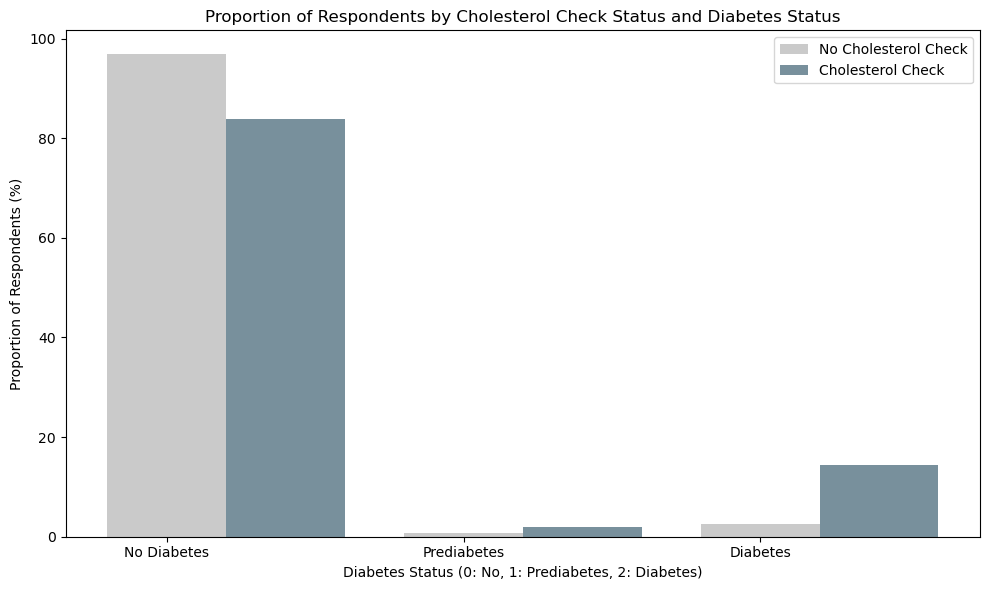

In [57]:

# Plot the proportions for cholesterol check status and diabetes status
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for the diabetes statuses
# colors = ['#CACACA','#78909C','#616161']

# Plot the no cholesterol check group
ax.bar(nocholcheck["Diabetes_012"], nocholcheck["proportion"], width=0.4, label="No Cholesterol Check", color=['#CACACA'], align='center')

# Plot the yes cholesterol check group, shifted slightly to the right
ax.bar(yescholcheck["Diabetes_012"] + 0.4, yescholcheck["proportion"], width=0.4, label="Cholesterol Check", color=['#78909C'], align='center')

# Set the labels and title
ax.set_xlabel("Diabetes Status (0: No, 1: Prediabetes, 2: Diabetes)")
ax.set_ylabel("Proportion of Respondents (%)")
ax.set_title("Proportion of Respondents by Cholesterol Check Status and Diabetes Status")
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['No Diabetes', 'Prediabetes', 'Diabetes'])

# Add a legend
ax.legend()

# Display the plot
plt.savefig("images/cholesterol_vs_diabetes.png")
plt.tight_layout()
plt.show()




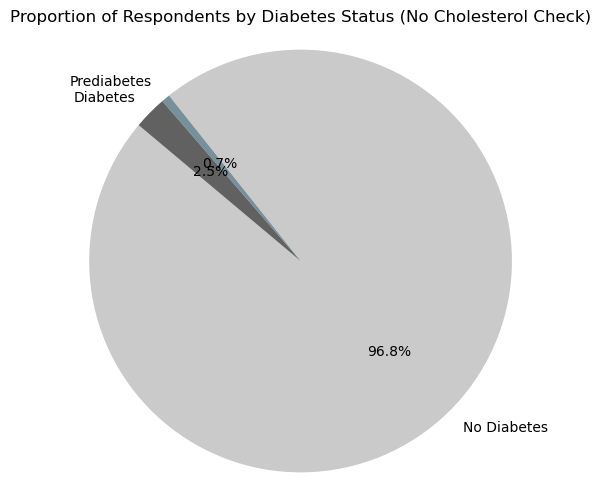

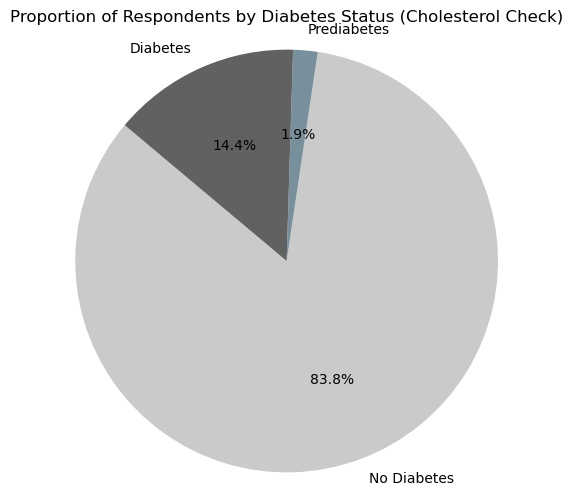

In [58]:

# Group by cholesterol check status and diabetes status
dia_chol_check = df_trimmed.groupby(["CholCheck", "Diabetes_012"]).size().reset_index(name='count')

# Separate the categories of those who did not have a cholesterol check (0) and those who did (1)
nocholcheck = dia_chol_check[dia_chol_check["CholCheck"] == 0].copy()
yescholcheck = dia_chol_check[dia_chol_check["CholCheck"] == 1].copy()

# Find the total respondents per category (cholesterol check and no cholesterol check)

# Create a new column for the proportion of respondents in each row out of their respective category
nocholcheck_sum = nocholcheck["count"].sum()
nocholcheck["proportion"] = (nocholcheck["count"] / nocholcheck_sum) * 100

yescholcheck_sum = yescholcheck["count"].sum()
yescholcheck["proportion"] = (yescholcheck["count"] / yescholcheck_sum) * 100

# Combine the two tables into a new DataFrame that shows the proportions
cholcheck_stack = pd.concat([nocholcheck, yescholcheck], ignore_index=True)

# Plot the data as pie charts
for chol_check_status, title in [(0, "No Cholesterol Check"), (1, "Cholesterol Check")]:
    # Filter the data for the current cholesterol check status
    data = cholcheck_stack[cholcheck_stack["CholCheck"] == chol_check_status]
    
    # Create the pie chart
    labels = ['No Diabetes', 'Prediabetes', 'Diabetes']
    sizes = data['proportion'].values
    colors = ['lightblue', 'lightgreen', 'lightcoral']
    
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, colors = ['#CACACA','#78909C','#616161'], autopct='%1.1f%%', startangle=140)
    plt.title(f"Proportion of Respondents by Diabetes Status ({title})")
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.savefig("images/cholesterol_vs_diabetes.png")
    plt.show()


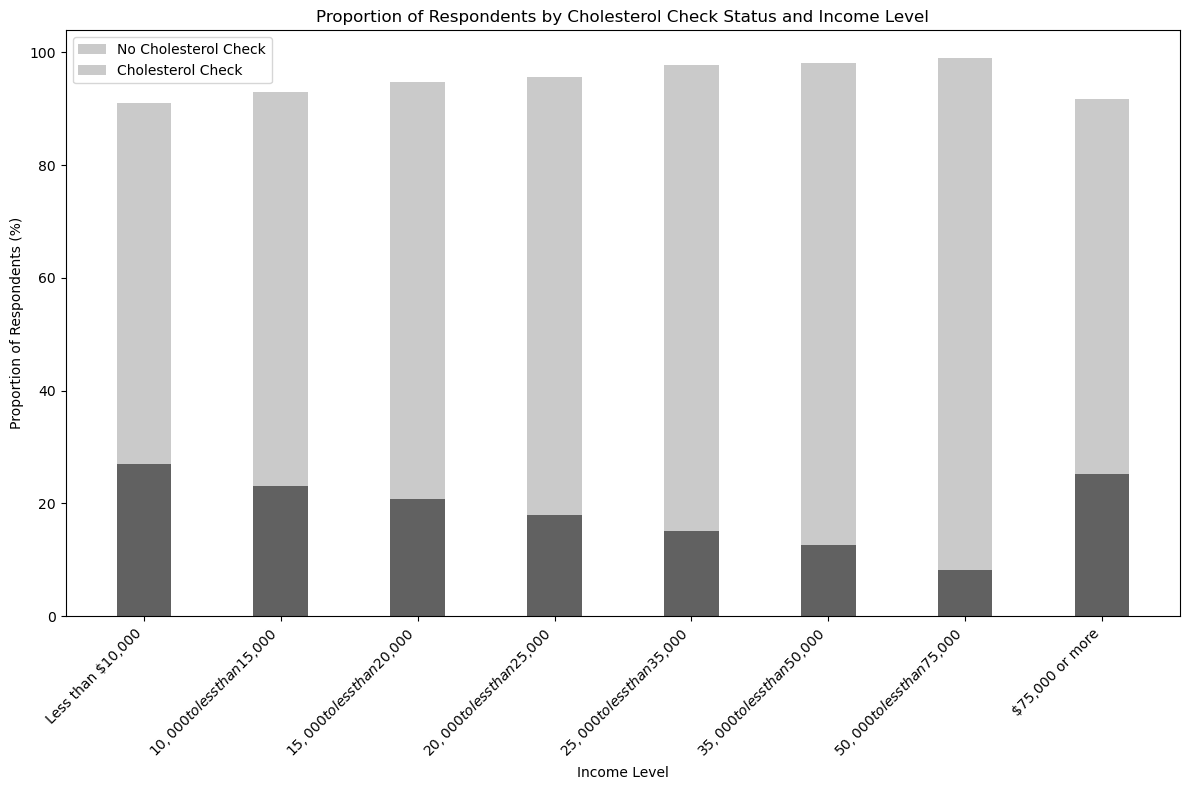

In [59]:

# Group by income
# Define the income scale mapping 
income_scale = {
    1: 'Less than $10,000',
    2: '$10,000 to less than $15,000',
    3: '$15,000 to less than $20,000',
    4: '$20,000 to less than $25,000',
    5: '$25,000 to less than $35,000',
    6: '$35,000 to less than $50,000',
    7: '$50,000 to less than $75,000',
    8: '$75,000 or more'
}

# Map the Income column to the descriptive categories
diabetes_df['Income'] = diabetes_df['Income'].map(income_scale)


# Group by income, cholesterol check status, and diabetes status
dia_income_chol = diabetes_df.groupby(["Income", "CholCheck", "Diabetes_012"]).size().reset_index(name='count')

# Separate categories based on cholesterol check status
nocholcheck_income = dia_income_chol[dia_income_chol["CholCheck"] == 0].copy()
yescholcheck_income = dia_income_chol[dia_income_chol["CholCheck"] == 1].copy()

# Calculate proportions
nocholcheck_income_sum = nocholcheck_income.groupby("Income")["count"].transform('sum')
nocholcheck_income["proportion"] = (nocholcheck_income["count"] / nocholcheck_income_sum) * 100

yescholcheck_income_sum = yescholcheck_income.groupby("Income")["count"].transform('sum')
yescholcheck_income["proportion"] = (yescholcheck_income["count"] / yescholcheck_income_sum) * 100

# Plot the proportions for cholesterol check status and diabetes status by income
fig, ax = plt.subplots(figsize=(12, 8))

# Colors for diabetes statuses
colors = ['#CACACA','#78909C','#616161']

# Plot the no cholesterol check group
ax.bar(nocholcheck_income["Income"], nocholcheck_income["proportion"], width=0.4, label="No Cholesterol Check", color=colors, align='center')

# Plot the yes cholesterol check group, shifted slightly to the right
ax.bar(yescholcheck_income["Income"], yescholcheck_income["proportion"], width=0.4, label="Cholesterol Check", color=colors, align='center')

# Set the labels and title
ax.set_xlabel("Income Level")
ax.set_ylabel("Proportion of Respondents (%)")
ax.set_title("Proportion of Respondents by Cholesterol Check Status and Income Level")
ax.set_xticks(range(len(income_scale)))
ax.set_xticklabels(list(income_scale.values()), rotation=45, ha="right")

# Add a legend
ax.legend()

# Display the plot
plt.savefig("images/cholesterol_vs_income.png")
plt.tight_layout()
plt.show()


In [60]:
# Create a chi squared test for cholesterol check vs income

from scipy.stats import chi2_contingency  # Import Chi-Square test function

contingency_table = pd.crosstab(diabetes_df['Income'], diabetes_df['CholCheck'])
chi2, p, dof, expected = chi2_contingency(contingency_table)


# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)


# Display the results
print("Contingency Table:")
print(contingency_table)
print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
print("\nExpected Frequencies:")
print(expected)

# Interpretation
if p < 0.05:
    print("\nThere is a statistically significant association between income level and cholesterol check status (p < 0.05).")
else:
    print("\nThere is no statistically significant association between income level and cholesterol check status (p >= 0.05).")

Contingency Table:
CholCheck                      0.0    1.0
Income                                   
$10,000 to less than $15,000   446  11337
$15,000 to less than $20,000   646  15348
$20,000 to less than $25,000   811  19324
$25,000 to less than $35,000   996  24887
$35,000 to less than $50,000  1441  35029
$50,000 to less than $75,000  1645  41574
$75,000 or more               3030  87355
Less than $10,000              455   9356

Chi-Square Test Results:
Chi-Square Statistic: 74.3458140215178
P-Value: 1.9470932694446034e-13
Degrees of Freedom: 7

Expected Frequencies:
[[  439.8652239  11343.1347761 ]
 [  597.06393882 15396.93606118]
 [  751.64951908 19383.35048092]
 [  966.22520498 24916.77479502]
 [ 1361.44315673 35108.55684327]
 [ 1613.38666824 41605.61333176]
 [ 3374.11680069 87010.88319931]
 [  366.24948754  9444.75051246]]

There is a statistically significant association between income level and cholesterol check status (p < 0.05).


Diabetes_012                       0.0       1.0       2.0
Income                                                    
$10,000 to less than $15,000  0.951325  0.985955  0.988658
$15,000 to less than $20,000  0.949938  0.973872  0.990471
$20,000 to less than $25,000  0.950839  0.980392  0.991613
$25,000 to less than $35,000  0.954165  0.986371  0.992229
$35,000 to less than $50,000  0.953699  0.995989  0.994519
$50,000 to less than $75,000  0.956608  0.985034  0.996391
$75,000 or more               0.963519  0.993076  0.996525
Less than $10,000             0.941383  0.974522  0.987411


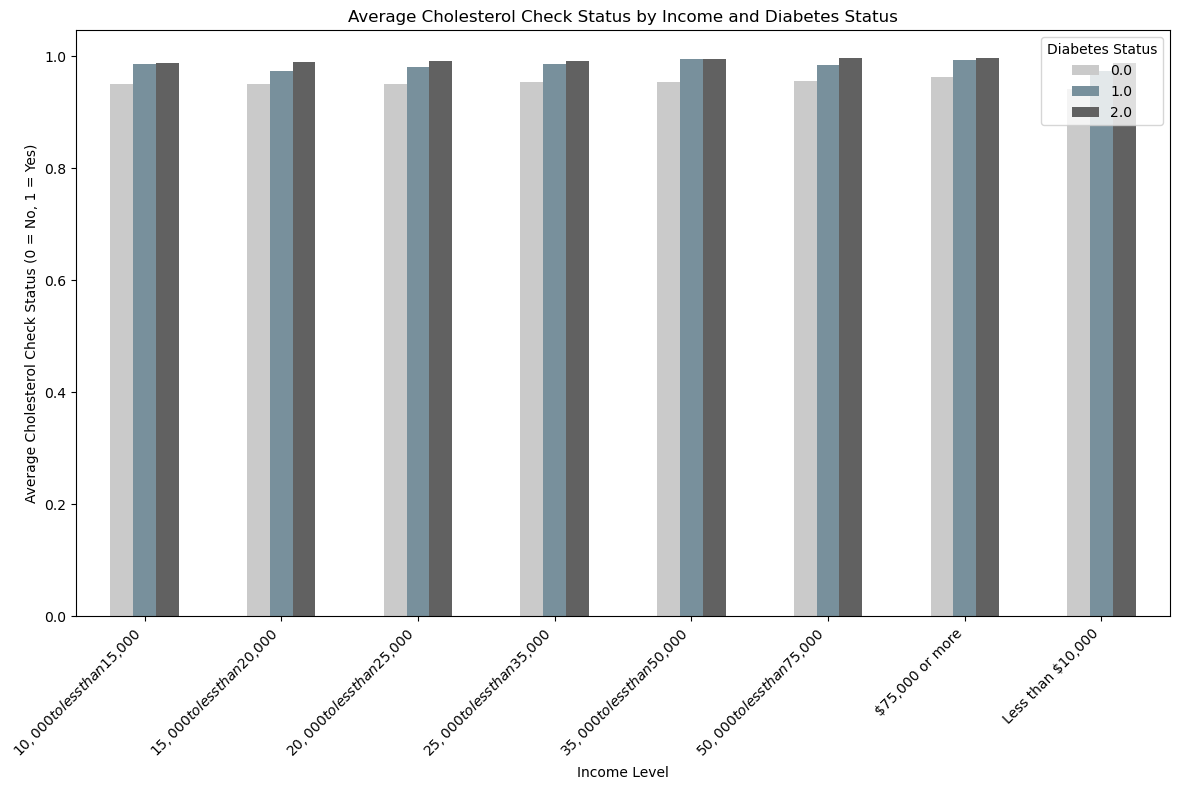

In [61]:
# Create a pivot table to summarize cholesterol check status by income and diabetes status
import seaborn as sns  # Import Seaborn for visualization



# Create a pivot table to summarize cholesterol check status by income and diabetes status
pivot_table = diabetes_df.pivot_table(
    values='CholCheck', 
    index='Income', 
    columns='Diabetes_012', 
    aggfunc='mean'
)

# Display the pivot table
print(pivot_table)

# Plot the pivot table as a bar plot using the specified colors
pivot_table.plot(kind='bar', figsize=(12, 8), color=['#CACACA','#78909C','#616161'])

# Customize the plot
plt.title("Average Cholesterol Check Status by Income and Diabetes Status")
plt.ylabel("Average Cholesterol Check Status (0 = No, 1 = Yes)")
plt.xlabel("Income Level")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Diabetes Status", loc='upper right')

# Show the plot
plt.savefig("images/cholesterol_vs_income.png")
plt.tight_layout()
plt.show()


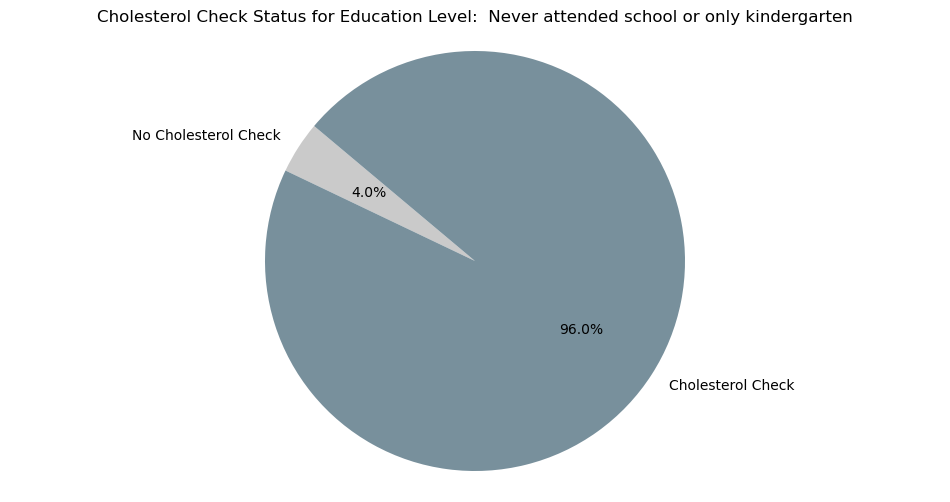

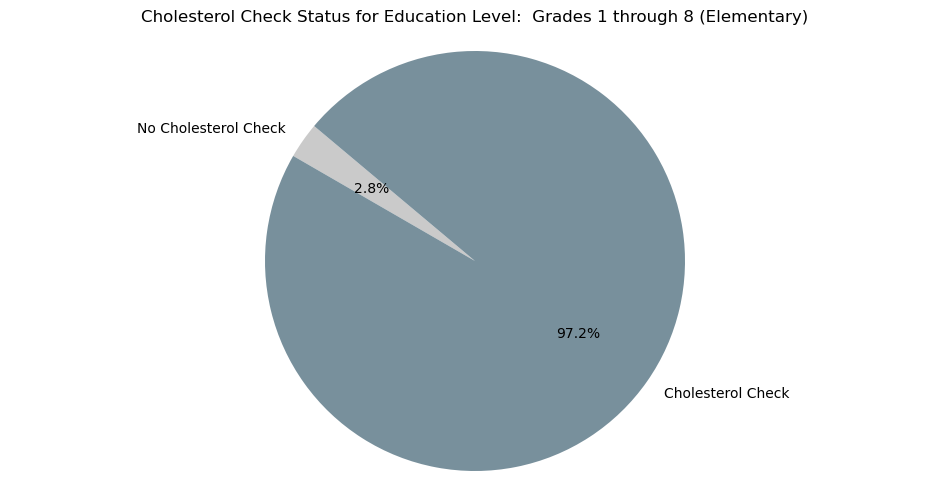

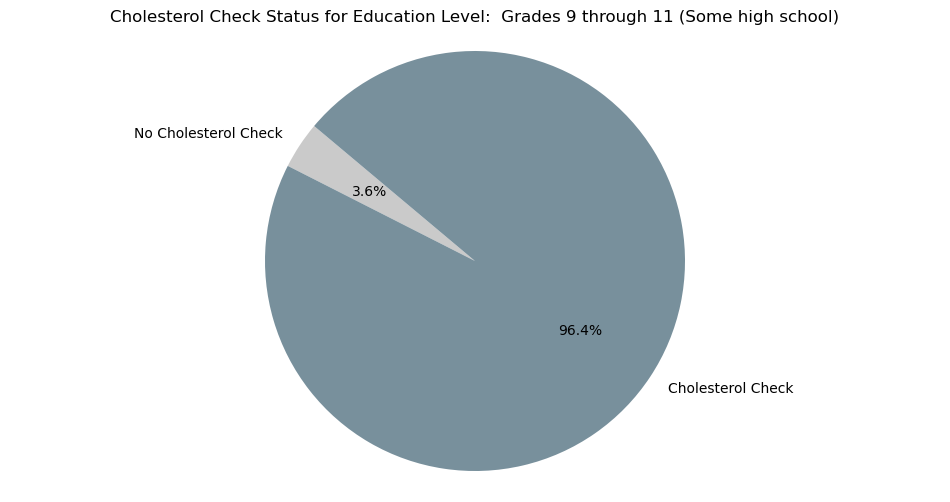

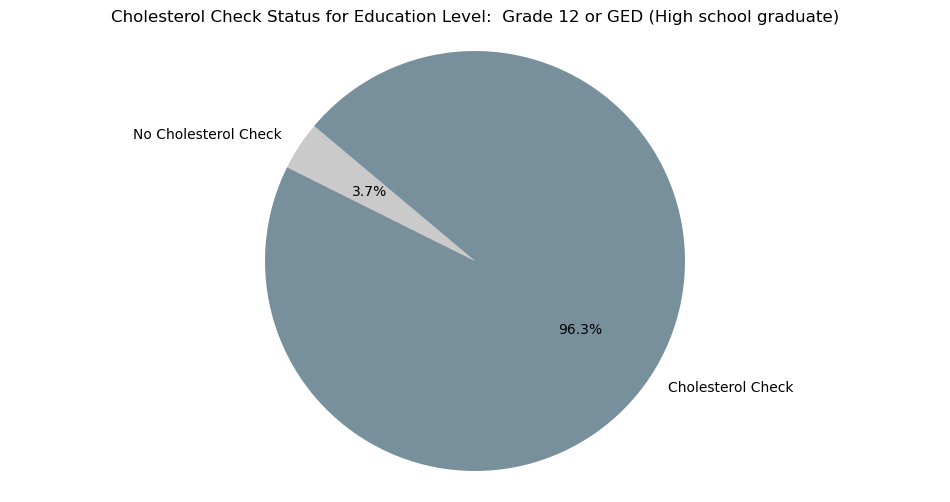

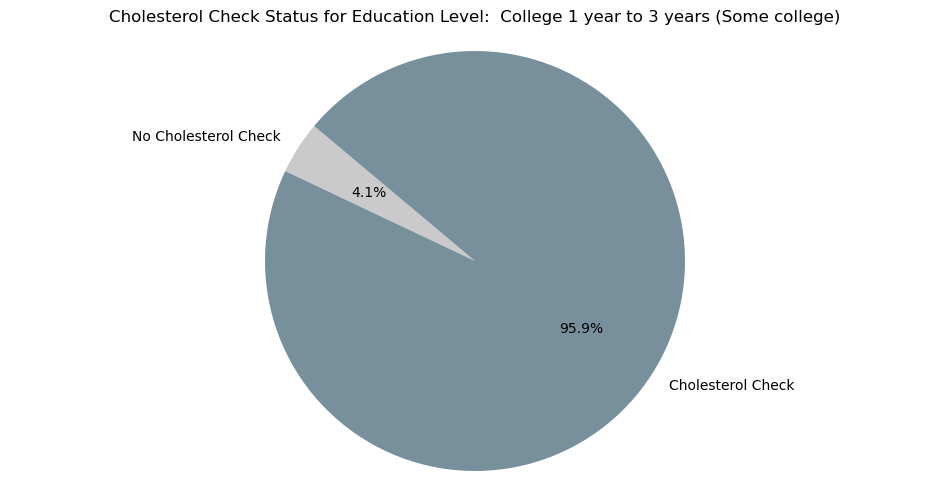

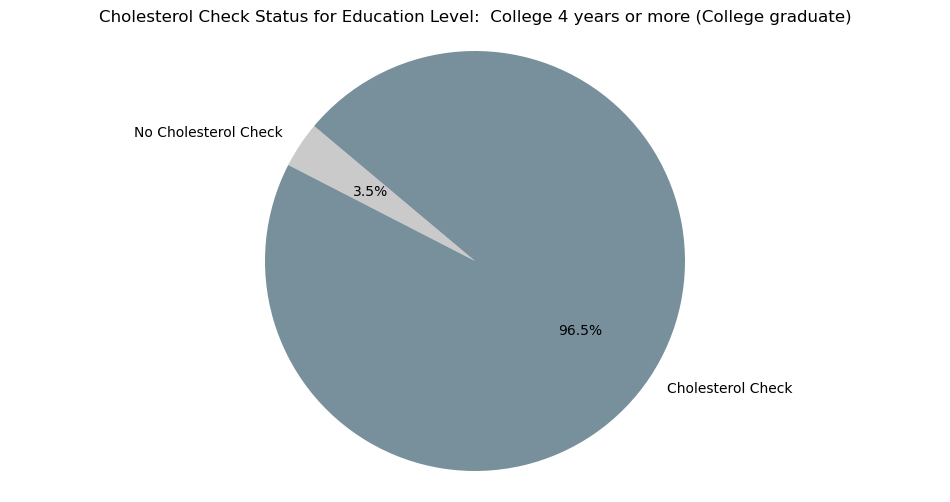

In [62]:
# Create pie charts to visualize the average cholesterol check status by education level and diabetes status.


# Define the education scale mapping
education_scale = {
    1: 'Never attended school or only kindergarten',
    2: 'Grades 1 through 8 (Elementary)',
    3: 'Grades 9 through 11 (Some high school)',
    4: 'Grade 12 or GED (High school graduate)',
    5: 'College 1 year to 3 years (Some college)',
    6: 'College 4 years or more (College graduate)'
}

# Map the Education column to the descriptive categories
diabetes_df['Education'] = diabetes_df['Education'].map(education_scale)

# Drop rows with missing data in the relevant columns
diabetes_df = diabetes_df.dropna(subset=['Education', 'CholCheck', 'Diabetes_012'])

# Group the data by Education and CholCheck to count occurrences
education_cholcheck = diabetes_df.groupby(['Education', 'CholCheck']).size().reset_index(name='count')

# Create a pie chart for each education level
i = 1
for education_level in education_scale.values():

    # Filter the data for the current education level
    level_data = education_cholcheck[education_cholcheck['Education'] == education_level]
    labels = ['No Cholesterol Check', 'Cholesterol Check']
    sizes = level_data['count'].values if not level_data.empty else [0, 0]
    # Filter the data for the current education level
    level_data = education_cholcheck[education_cholcheck['Education'] == education_level]
    
    # Only create a pie chart if there is data
    if not level_data.empty:
        labels = ['No Cholesterol Check', 'Cholesterol Check']
        sizes = level_data['count'].values
        colors = ['#CACACA','#78909C','#616161']
        
        # Plot the pie chart
        plt.figure(figsize=(12, 6))
        plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
        plt.title(f"Cholesterol Check Status for Education Level:  {education_level}")
        plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
       # plt.savefig("images/cholesterol_vs_education.png")
        plt.savefig(f"images/cholesterol_vs_education{i}.png")
        plt.show()
    i += 1
   

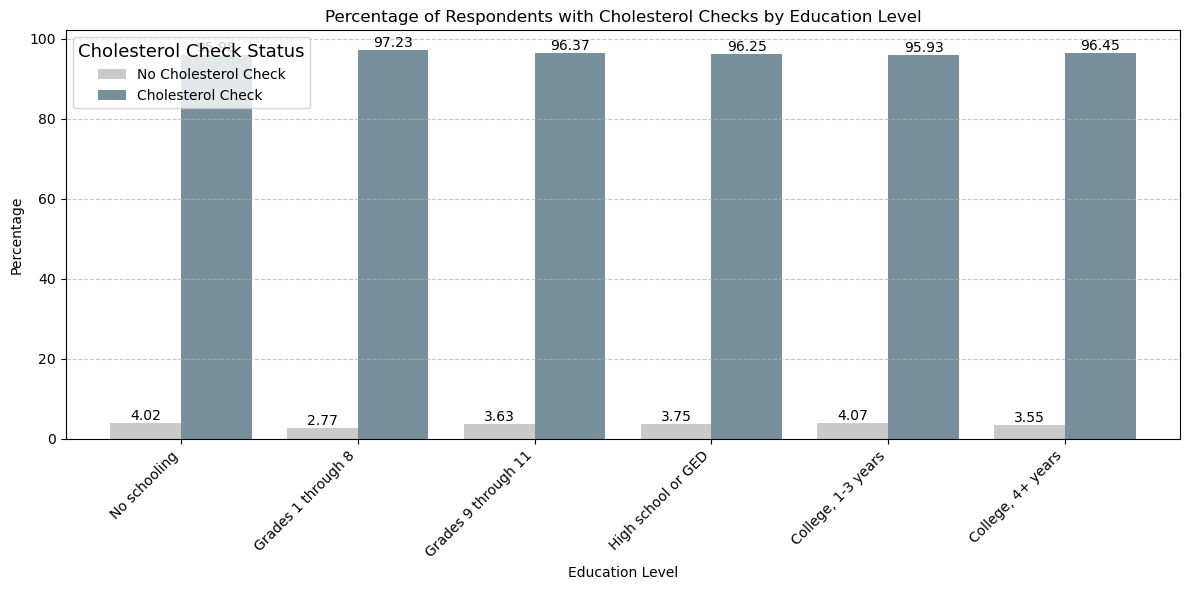

In [63]:
# Create a bar chart to visualize the average cholesterol check status by education level and diabetes status.


# Group by education and cholesterol check status, then count the occurrences
dia_edu = df_trimmed.groupby(["Education", "CholCheck"]).size().reset_index(name='count')

# Calculate the sum of responses for each education group
education_group_sum = dia_edu.groupby('Education')['count'].transform('sum')

# Calculate the proportions
dia_edu['proportion'] = (dia_edu['count'] / education_group_sum) * 100

# Pivot the table to prepare for plotting
edu_pivot_df = dia_edu.pivot(index='Education', columns='CholCheck', values='proportion')

# Rename columns for clarity
edu_pivot_df.columns = ['No Cholesterol Check', 'Cholesterol Check']

# Map the education levels for better display
index_mapping = {
    1: 'No schooling',
    2: 'Grades 1 through 8',
    3: 'Grades 9 through 11',
    4: 'High school or GED',
    5: 'College, 1-3 years',
    6: 'College, 4+ years',
}
edu_pivot_df.index = edu_pivot_df.index.map(index_mapping)

# Define colors for the bar chart
colors = ['#CACACA','#78909C']

# Plot the table as a bar chart
ax = edu_pivot_df.plot(kind='bar', width=0.8, figsize=(12, 6), color=colors)
plt.title('Percentage of Respondents with Cholesterol Checks by Education Level')
plt.xlabel('Education Level')
plt.ylabel('Percentage')
plt.xticks(rotation=45, ha="right")
plt.legend(title='Cholesterol Check Status', title_fontsize='13')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("images/cholesterol_vs_education.png")

# Label the percentages on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', label_type='edge')

# Display the plot
plt.tight_layout()
plt.show()




In [64]:
# Education data shown with the Chi-Square Test
# Create a contingency table

from scipy.stats import chi2_contingency  # Import Chi-Square test function
contingency_table = pd.crosstab(diabetes_df['Education'], diabetes_df['CholCheck'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display the results
colors = ['#CACACA','#78909C','#616161']
print("Contingency Table:")
print(contingency_table)
print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
print("\nExpected Frequencies:")
print(expected)
plt.savefig("images/cholesterol_vs_education.png")
# Interpretation
if p < 0.05:
    print("\nThere is a statistically significant association between education level and cholesterol check status (p < 0.05).")
else:
    print("\nThere is no statistically significant association between education level and cholesterol check status (p >= 0.05).")

# Create a summary DataFrame for the Chi-Square test results
chi_square_results = pd.DataFrame({
    'Chi-Square Statistic': [chi2],
    'P-Value': [p],
    'Degrees of Freedom': [dof]
})

Contingency Table:
CholCheck                                    0.0     1.0
Education                                               
College 1 year to 3 years (Some college)    2845   67065
College 4 years or more (College graduate)  3810  103515
Grade 12 or GED (High school graduate)      2352   60398
Grades 1 through 8 (Elementary)              112    3931
Grades 9 through 11 (Some high school)       344    9134
Never attended school or only kindergarten     7     167

Chi-Square Test Results:
Chi-Square Statistic: 42.82749480123138
P-Value: 4.00481765876846e-08
Degrees of Freedom: 5

Expected Frequencies:
[[2.60977491e+03 6.73002251e+04]
 [4.00649539e+03 1.03318505e+05]
 [2.34248857e+03 6.04075114e+04]
 [1.50927192e+02 3.89207281e+03]
 [3.53818433e+02 9.12418157e+03]
 [6.49550615e+00 1.67504494e+02]]

There is a statistically significant association between education level and cholesterol check status (p < 0.05).


<Figure size 640x480 with 0 Axes>

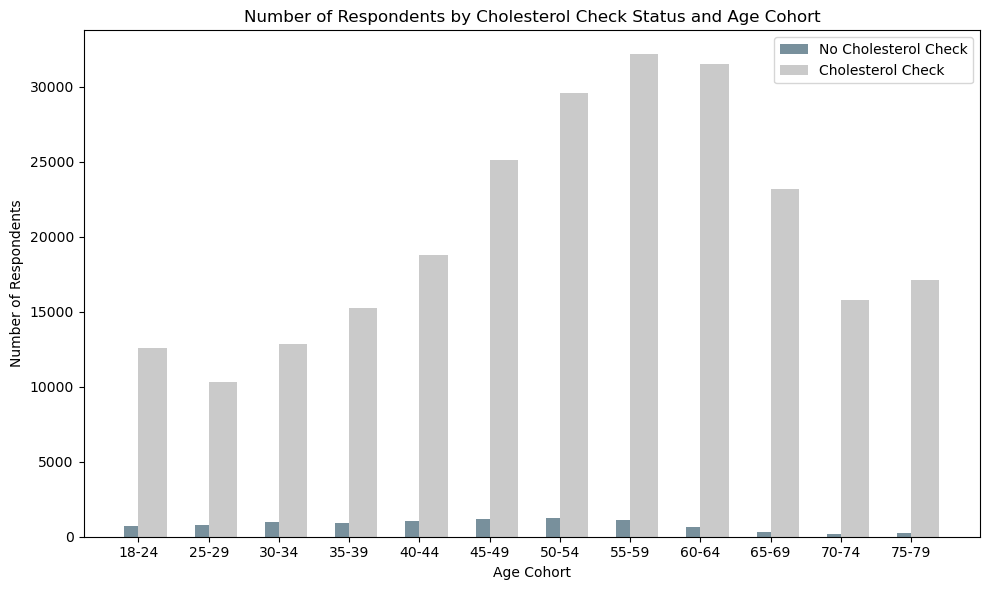

In [65]:
# Cholesterol checks by age


# Map the 13-level age categories (_AGEG5YR) to their corresponding age ranges
age_map = {
    1: 18, 2: 25, 3: 30, 4: 35, 5: 40, 6: 45,
    7: 50, 8: 55, 9: 60, 10: 65, 11: 70, 12: 75, 13: 80
}

# Apply the mapping to create a new 'Mapped_Age' column
diabetes_df['Mapped_Age'] = diabetes_df['Age'].map(age_map)


# Define the new age cohorts using bins and labels
age_bins = [18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
age_labels = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']




# Create a new column in the DataFrame for age cohorts
diabetes_df['Age_Cohort'] = pd.cut(diabetes_df['Mapped_Age'], bins=age_bins, labels=age_labels, include_lowest=True)

# Drop rows with missing data in the relevant columns
diabetes_df = diabetes_df.dropna(subset=['Age_Cohort', 'CholCheck'])

# Group by age cohort and cholesterol check status, and count the number of participants for each category
dia_age_chol = diabetes_df.groupby(["Age_Cohort", "CholCheck"], observed=True).size().reset_index(name='count')

# Plot the data as a bar chart
fig, ax = plt.subplots(figsize=(10, 6))

# Separate data into groups based on cholesterol check status
nocholcheck = dia_age_chol[dia_age_chol["CholCheck"] == 0].copy()
yescholcheck = dia_age_chol[dia_age_chol["CholCheck"] == 1].copy()

# Plotting the no cholesterol check group
ax.bar(nocholcheck["Age_Cohort"], nocholcheck["count"], width=0.4, label="No Cholesterol Check", align='center', color = ['#78909C'])
colors = ['#78909C','#616161', '#CACACA']

# Plotting the cholesterol check group, shifted slightly to the right
ax.bar(yescholcheck["Age_Cohort"], yescholcheck["count"], width=0.4, label="Cholesterol Check", align='edge', color= [ '#CACACA'])
colors = ['#78909C','#616161', '#CACACA']
# Set the labels and title
colors = ['#78909C','#616161', '#CACACA']
ax.set_xlabel("Age Cohort")
ax.set_ylabel("Number of Respondents")
ax.set_title("Number of Respondents by Cholesterol Check Status and Age Cohort")
ax.legend()
plt.savefig("images/cholesterol_vs_age.png")

# Display the plot
plt.tight_layout()
plt.show()




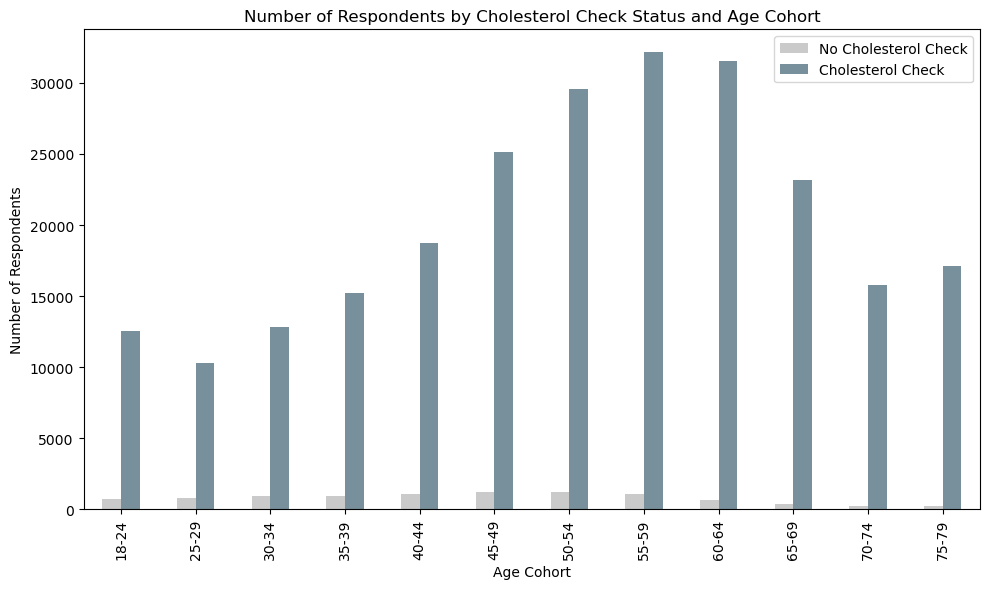

In [66]:
# Cholesterol by age shown in a pivot table 

pivot_table = diabetes_df.pivot_table(
    values='Mapped_Age', 
    index='Age_Cohort', 
    columns='CholCheck', 
    aggfunc='count', 
    fill_value=0, 
    observed=True  # Set observed=True to silence the warning and use future behavior
)

# Plot the pivot table as a bar chart 
colors = ['#CACACA','#78909C','#616161']
pivot_table.plot(kind='bar', figsize=(10, 6), color=colors)


# Set the labels and title
plt.xlabel("Age Cohort")
plt.ylabel("Number of Respondents")
plt.title("Number of Respondents by Cholesterol Check Status and Age Cohort")
plt.legend(["No Cholesterol Check", "Cholesterol Check"])
plt.savefig("images/cholesterol_vs_age.png")

# Display the plot
plt.tight_layout()
plt.show()


In [67]:
# Cholesterol by age chi- squared test


# Map the 13-level age categories (_AGEG5YR) to their corresponding age ranges
age_map = {
    1: 18, 2: 25, 3: 30, 4: 35, 5: 40, 6: 45,
    7: 50, 8: 55, 9: 60, 10: 65, 11: 70, 12: 75, 13: 80
}

# Apply the mapping to create a new 'Mapped_Age' column
diabetes_df['Mapped_Age'] = diabetes_df['Age'].map(age_map)

# Define the new age cohorts using bins and labels
age_bins = [18, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
age_labels = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80+']

# Create a new column in the DataFrame for age cohorts
diabetes_df['Age_Cohort'] = pd.cut(diabetes_df['Mapped_Age'], bins=age_bins, labels=age_labels, include_lowest=True)

# Drop rows with missing data in the relevant columns
diabetes_df = diabetes_df.dropna(subset=['Age_Cohort', 'CholCheck'])

# Create a contingency table between Age_Cohort and CholCheck
contingency_table = pd.crosstab(diabetes_df['Age_Cohort'], diabetes_df['CholCheck'])

# Perform the Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Display the results
print("Contingency Table:")
print(contingency_table)
print("\nChi-Square Test Results:")
print(f"Chi-Square Statistic: {chi2}")
print(f"P-Value: {p}")
print(f"Degrees of Freedom: {dof}")
print("\nExpected Frequencies:")
print(expected)

# Interpretation
if p < 0.05:
    print("\nThere is a statistically significant association between age cohort and cholesterol check status (p < 0.05).")
else:
    print("\nThere is no statistically significant association between age cohort and cholesterol check status (p >= 0.05).")




Contingency Table:
CholCheck    0.0    1.0
Age_Cohort             
18-24        724  12574
25-29        797  10326
30-34        968  12855
35-39        911  15246
40-44       1059  18760
45-49       1207  25107
50-54       1247  29585
55-59       1089  32155
60-64        657  31537
65-69        344  23189
70-74        213  15767
75-79        254  17109

Chi-Square Test Results:
Chi-Square Statistic: 2371.0519678520427
P-Value: 0.0
Degrees of Freedom: 11

Expected Frequencies:
[[  496.420924   12801.579076  ]
 [  415.22709713 10707.77290287]
 [  516.01943393 13306.98056607]
 [  603.14880952 15553.85119048]
 [  739.85308262 19079.14691738]
 [  982.31464838 25331.68535162]
 [ 1150.97382529 29681.02617471]
 [ 1241.0149795  32002.9850205 ]
 [ 1201.81795963 30992.18204037]
 [  878.49854147 22654.50145853]
 [  596.54131189 15383.45868811]
 [  648.16938663 16714.83061337]]

There is a statistically significant association between age cohort and cholesterol check status (p < 0.05).


Summary Analysis: Cholesterol Checks by Age, Education, and Income:

18-50 Cohort: This younger cohort showed a high rate of cholesterol checks, but a slightly larger proportion of this group had not undergone a cholesterol check compared to older cohorts.
51-64 Cohort: The middle-age cohort exhibited a higher compliance rate for cholesterol checks, likely reflecting increased health awareness or medical advice as individuals approach retirement age.
65-84 Cohort: The oldest cohort had the highest proportion of individuals who had undergone cholesterol checks, which aligns with the increased health monitoring typically recommended for older adults.

Lower Education Levels: Individuals with lower educational attainment, particularly those who never attended school or only completed elementary education, had the lowest rates of cholesterol checks.
Higher Education Levels: Respondents with higher education levels, especially those with college education, were significantly more likely to have undergone cholesterol checks. This suggests that higher education is associated with greater health awareness and access to healthcare services.
Statistical Significance: The chi-square test indicated a statistically significant association between education level and cholesterol check status, reinforcing the importance of education in preventive healthcare.

Lower Income Groups: Individuals in lower income brackets were less likely to have undergone cholesterol checks. This may be due to financial barriers, lack of access to healthcare, or lower health literacy.
Higher Income Groups: Those in higher income brackets had a significantly higher rate of cholesterol checks, suggesting that income positively influences access to healthcare services and the ability to afford preventive care.
Economic Disparities: The analysis highlights the disparities in healthcare access and utilization based on income, with wealthier individuals being more proactive in managing their health through regular cholesterol checks.


The analysis of cholesterol checks across different demographic indicators—age, education, and income—reveals clear patterns of health behavior and access to preventive care. Older adults, those with higher educational attainment, and individuals with higher incomes are more likely to have undergone cholesterol checks. These findings underscore the critical role of socioeconomic factors in healthcare access and the importance of targeted public health interventions to increase preventive care among younger, less educated, and lower-income populations. By addressing these disparities, we can improve overall public health outcomes and reduce the risk of cardiovascular diseases associated with high cholesterol levels.

## Muad

## Sophia

## Conclusions and Bonus Workspace